# Simulating a point mass door attached to spring damper system
In this notebook we attempt to simulate the following equation numerically:
$$m\ddot{x} + \gamma \dot{x} + kx = -F_{ext}$$

For now we consider the external force to be 0 (Solving the homogeneos form). A source term can be easily added.

In [3]:
using DifferentialEquations
using LinearAlgebra
using SparseArrays
using Plots

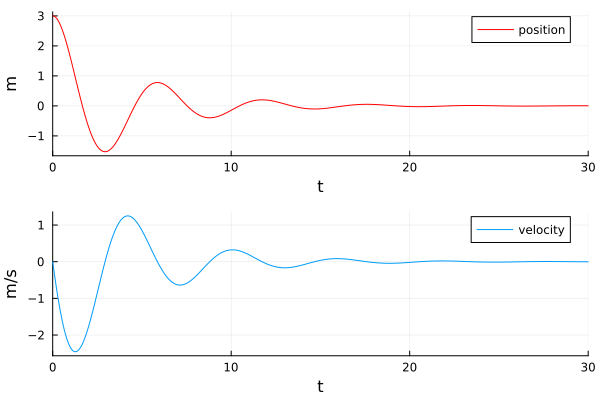

In [12]:
include("analytical_plots.jl")
import .PointMass

problem = PointMass.One_PointmassProblem(
    m=50.0, 
    γ=23.0, 
    k=60.0, 
    v0=0.0, 
    x0=3.0, 
    F=0.0
)

sol = PointMass.single_dof_numerical(problem, tspan)

p1 = plot(sol, vars=2, label="position", ylabel="m", color=:red)
p2 = plot(sol, vars=1, label="velocity", ylabel="m/s")

plot(p1, p2, layout=(2, 1))

### Simulating 2 point masses connected by springs

We aim to solve the equations:

$$m_1u_1'' = -(k_1+k_2)u_1 + k_2u_2$$
$$m_2u_2'' =  k_2u_1 - (k_2+k_3)u_2$$

Tsit5(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false),)

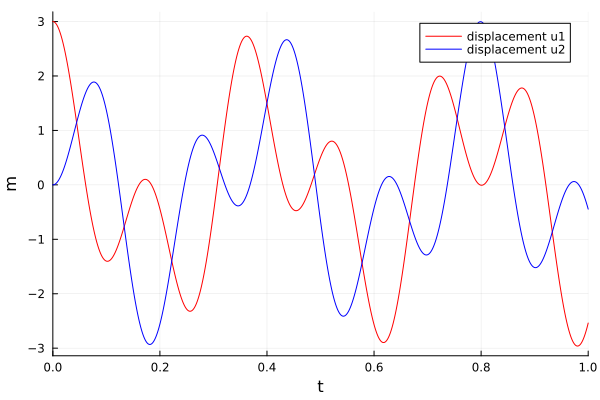

In [12]:
M = [40, 40]
K = [10000, 20000, 10000]
U0 = [3, 0]
tspan = (0, 1)

function two_degree_eq!(ddu, du, u, p, t)
    ddu[1] = -(K[1]+K[2])*u[1] / M[1] + K[2]*u[2] / M[1]
    ddu[2] = K[2]*u[1]/M[2] - (K[2] + K[3])*u[2] / M[2] 
end

function solve_eq(U0, tspan)
    prob = SecondOrderODEProblem(two_degree_eq!,[0,0], U0, tspan)                    
    sol = solve(prob)
    print(sol.alg) 
    sol
end

sol = solve_eq(U0, tspan)
plot(sol, vars=[3], label="displacement u1", xlabel="t", ylabel="m", color=:red)
plot!(sol, vars=[4], label="displacement u2", xlabel="t", ylabel="m", color=:blue)

### Point mass with collisions

![Alt text](../figures/spring-damper-collision.png)

To simulate this scenario we employ the same strategy as for the spring damper system in the beggining. We will use a callback function that is called by julia when our object reaches the coordinate of the walls.

We assume an elastic collision so we can get the new velocity from the formula:
$$v' = \frac{m - m_{wall}}{m + m_{wall}} \cdot v$$

Collision at time: 0.5555605987997361, x-coordinate: 4.999999999998218


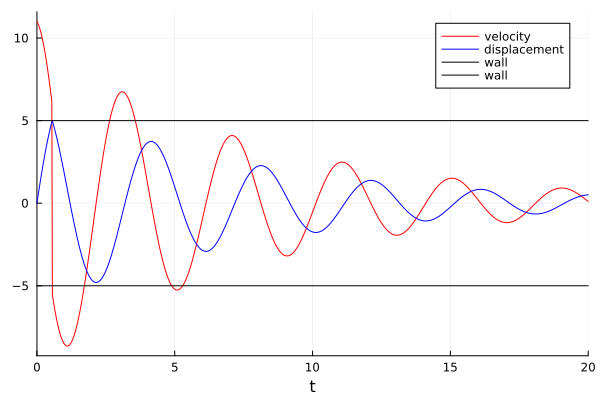

In [60]:

tspan = (0.0,20.0)      
Uᵣ = 5.0 # the wall is placed at 5 units to the right of the object
Uₗ = -5.0 # second wall is placed at 5 units to the left of the object
Mₗ = 1000 # mass of the wall

function spring_damper1D!(du, u, p, t)
    m, k, γ = p                                    
    du[1] = -1/m * (k*u[2] + γ*u[1]) 
    du[2] = u[1]                                                                 
end                                                                              

function condition(u, t, integrator) 
    (u[2]-Uₗ) * (u[2] - Uᵣ) # collision happens either at Ul or -Ul
end 

function affect!(integrator)
    coeff = (integrator.p[1] - Mₗ) / (integrator.p[1] + Mₗ) # assume wall has mass Ml, doesn't move and elastic collision occurs
    integrator.u[1] =  coeff * integrator.u[1]
    print("Collision at time: $(integrator.t), x-coordinate: $(integrator.u[2])\n")
end

function init_equation(v₀, x₀)                                                                   
    p = [40, 100, 10]                                                             
    prob = ODEProblem(spring_damper1D!,[v₀, x₀],tspan, p)                                                 
end

prob = init_equation(11.0, 0)
cb = ContinuousCallback(condition, affect!)
sol = solve(prob,callback=cb)

plot(sol, vars=[1], label="velocity", color = :red)
plot!(sol, vars=[2], label="displacement", color = :blue)

plot!(sol.t, repeat([Uᵣ], size(sol.t)[1]), label="wall", color = :black)
plot!(sol.t, repeat([Uₗ], size(sol.t)[1]), label="wall", color = :black)

# Beam Deflection


In [1]:
include("./dynamic_eq.jl")
import .DynamicEq

p = DynamicEq.BeamProblem(
    N=100,
    L=1,
    μ=1,
    xp=50,
    EI=5600,
    f=DynamicEq.point_load(500)
)

sol = DynamicEq.dynamic_eq_numerical(p, (0, 1.0))
# plot(sol.u[end])

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase ~/.julia/packages/SciMLBase/4XvOU/src/performance_warnings.jl:32
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/4XvOU/src/integrator_interface.jl:580


retcode: MaxIters
Interpolation: specialized 4th order "free" interpolation
t: 999880-element Vector{Float64}:
 0.0
 6.15159919542394e-7
 8.818959660082743e-7
 1.413040736783729e-6
 1.7910759352679554e-6
 2.2899076998729953e-6
 2.7801302322278013e-6
 3.2866340324571143e-6
 3.847539267628563e-6
 4.381529314983864e-6
 4.960342774537358e-6
 5.504956092071081e-6
 6.104081767942163e-6
 ⋮
 0.29364359823676134
 0.293643887852379
 0.2936441726781496
 0.2936444622895033
 0.29364474582141753
 0.29364503599985897
 0.2936453215351036
 0.2936456123365615
 0.29364589921608164
 0.29364619053681745
 0.2936464774535456
 0.29364676855789024
u: 999880-element Vector{RecursiveArrayTools.ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}}}:
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

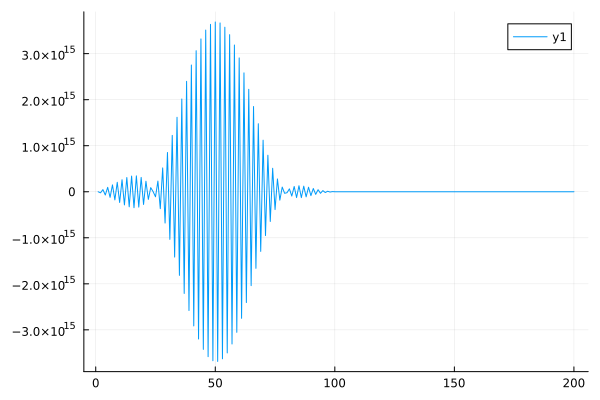

In [4]:
plot(sol.u)